# Out-of-Sample (OOS) Embedding

Suppose we've embedded the nodes of a graph into Euclidean space using Adjacency Spectral Embedding (ASE) or Laplacian Spectral Embeding (LSE).  
Then, suppose we gain access to new nodes not seen in the original graph. We sometimes wish to determine their latent positions without the computationally-expensive task of re-embedding an entirely new adjacency matrix.

More formally, suppose we have computed the embedding $\hat{X} \in \textbf{R}^{n \times d}$ from some adjacency matrix $A \in \textbf{R}^{n \times n}$.  
Suppose we then obtain some new vertex with adjacency vector $w \in \textbf{R}^n$ or new vertices with "adjacency" matrix $W \in \textbf{R}^{m \times n}$, with $m$ the number of new vertices. We wish to estimate the latent positions for these new vertices.

Here, an "adjacency vector" $w$ is a vector with $n$ elements, $n$ being the number of in-sample vertices, and a 1 in the $i_{th}$ position if the out-of-sample vertex has an edge with in-sample vertex $i$ in the unweighted case.

$W \in \textbf{R}^{m \times n}$ is a matrix with each row being an adjacency vector, for $m$ out-of-sample vertices.

We can obtain this estimation with ASE's or LSE's `transform` method.  
Running through the Adjacency Spectral Embedding tutorial is recommended prior to this tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from numpy.random import normal, poisson

from graspologic.simulations import sbm
from graspologic.embed import AdjacencySpectralEmbed as ASE
from graspologic.embed import LaplacianSpectralEmbed as LSE
from graspologic.plot import heatmap, pairplot
from graspologic.utils import remove_vertices

np.random.seed(1234)
import warnings
warnings.filterwarnings('ignore')

/home/runner/.cache/pypoetry/virtualenvs/graspologic-pkHfzCJ8-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Undirected out-of-sample prediction

Here, we embed an undirected two-block stochastic block model with ASE. We then use its transform method to find an out-of-sample prediction for both a single vertex and multiple vertices.  

We begin by generating data.

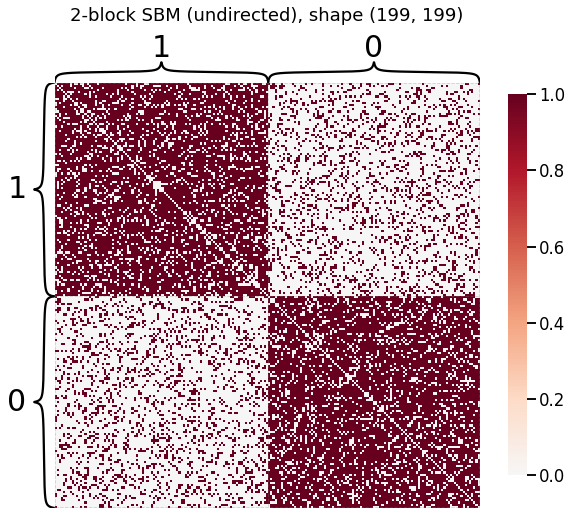

In [2]:
# Generate parameters
nodes_per_community = 100
P = np.array([[0.8, 0.2],
              [0.2, 0.8]])

# Generate an undirected Stochastic Block Model (SBM)
undirected, labels_ = sbm(2*[nodes_per_community], P, return_labels=True)
labels = list(labels_)

# Grab out-of-sample vertices
oos_idx = 0
oos_labels = labels.pop(oos_idx)
A, a = remove_vertices(undirected, indices=oos_idx, return_removed=True)

# plot our SBM
heatmap(A, title=f'2-block SBM (undirected), shape {A.shape}', inner_hier_labels=labels);

### Embedding (ASE)

We then generate an embedding with ASE, and we use its `transform` method to determine our best estimate for the latent position of the out-of-sample vertex.

In [3]:
# Generate an embedding with ASE
ase = ASE(n_components=2)
X_hat_ase = ase.fit_transform(A)

# predicted latent positions
w_ase = ase.transform(a)
w_ase

array([ 0.69563801, -0.59472394])

#### Plotting out-of-sample embedding

Here, we plot the original latent positions as well as the out-of-sample vertices. Note that the out-of-sample vertices are near their expected latent positions despite not having been run through the original embedding.  
In this plot, the stars are the out-of-sample latent positions, and the dots are the in-sample latent positions.

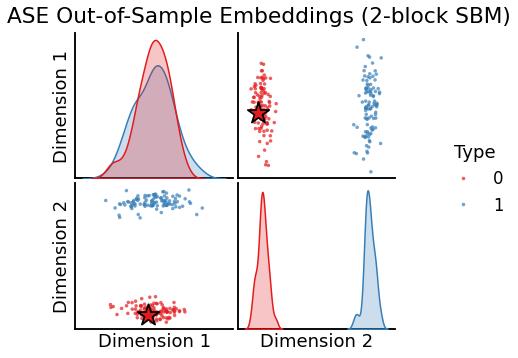

In [4]:
def plot_oos(X_hat, oos_vertices, labels, oos_labels, title):
    # Plot the in-sample latent positions
    plot = pairplot(X_hat, labels=labels, title=title)

    # generate an out-of-sample dataframe
    oos_vertices = np.atleast_2d(oos_vertices)
    data = {'Type': oos_labels, 
          'Dimension 1': oos_vertices[:, 0], 
          'Dimension 2': oos_vertices[:, 1]}
    oos_df = pd.DataFrame(data=data)
    
    # update plot with out-of-sample latent positions,
    # plotting out-of-sample latent positions as stars
    plot.data = oos_df
    plot.hue_vals = oos_df["Type"]
    plot.map_offdiag(sns.scatterplot, s=500,
                     marker="*", edgecolor="black")
    plot.tight_layout()
    return plot

# Plot all latent positions
plot_oos(X_hat_ase, w_ase, labels=labels, oos_labels=[0], title="ASE Out-of-Sample Embeddings (2-block SBM)");

### Embeding (LSE)
Similarly, we can also use Laplacian Spectral Embedding (LSE). We generate an embedding with its transform method to determine our best estimate for the latent position of the out-of-sample vertex.

In [5]:
# Generate an embedding with ASE
lse = LSE(n_components=2)
X_hat_lse = lse.fit_transform(A)

# predicted latent positions
w_lse = lse.transform(a)
w_lse

array([[ 0.07091005, -0.06055902]])

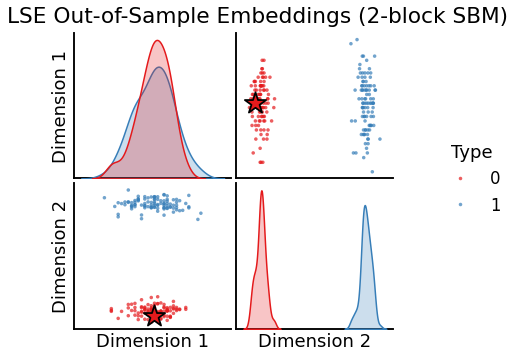

In [6]:
plot_oos(X_hat_lse, w_lse, labels=labels, oos_labels=[0], title="LSE Out-of-Sample Embeddings (2-block SBM)");

### Passing in multiple out-of-sample vertices

You can pass a 2d numpy array into `transform`. The rows are the out-of-sample vertices, and the columns are their edges to the in-sample vertices.

In [7]:
# Grab out-of-sample vertices
labels = list(labels_)
oos_idx = [0, -1]
oos_labels = [labels.pop(i) for i in oos_idx]
A, a = remove_vertices(undirected, indices=oos_idx, return_removed=True)

# our out-of-sample array is m x n
print(f"a is {type(a)} with shape {a.shape}")

a is <class 'numpy.ndarray'> with shape (2, 198)


The out-of-sample prediction output has dimensions (2, 2)



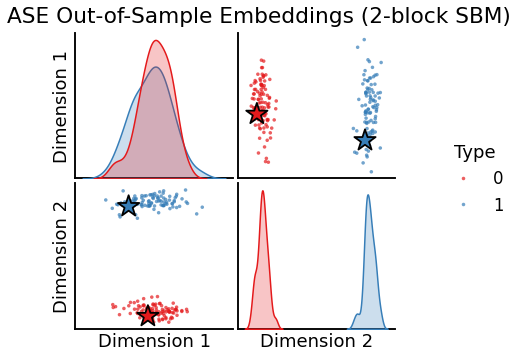

In [8]:
# Generate an embedding with ASE
ase = ASE(n_components=2)
X_hat_ase = ase.fit_transform(A)

# predicted latent positions
w_ase = ase.transform(a)
print(f"The out-of-sample prediction output has dimensions {w_ase.shape}\n")

# Plot all latent positions
plot_oos(X_hat_ase, w_ase, labels, oos_labels=oos_labels,
         title="ASE Out-of-Sample Embeddings (2-block SBM)");

The out-of-sample prediction output has dimensions (2, 2)



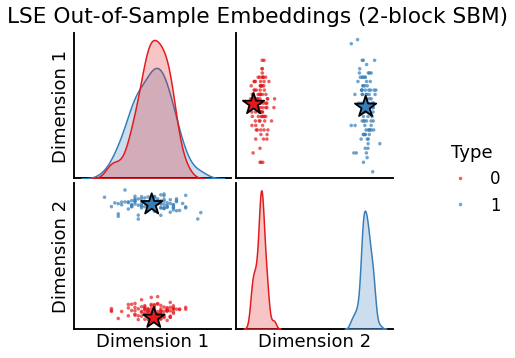

In [9]:
# Generate an embedding with LSE
lse = LSE(n_components=2)
X_hat_lse = lse.fit_transform(A)

# predicted latent positions
w_lse = lse.transform(a)
print(f"The out-of-sample prediction output has dimensions {w_lse.shape}\n")

# Plot all latent positions
plot_oos(X_hat_lse, w_lse, labels, oos_labels=oos_labels,
         title="LSE Out-of-Sample Embeddings (2-block SBM)");

## Directed out-of-sample prediction

Not all graphs are undirected. When finding out-of-sample latent positions for directed graphs, $A \in \textbf{R}^{n \times n}$ is not symmetric. $A_{i,j}$ represents the edge from node $i$ to node $j$, whereas $A_{j, i}$ represents the edge from node $j$ to node $i$.

To account for this, we pass a tuple (out_oos, in_oos) into the `transform` method. It then outputs a tuple of (out_latent_prediction, in_latent_prediction).  
Here, "out" means "edges from out-of-sample vertices to in-sample vertices"

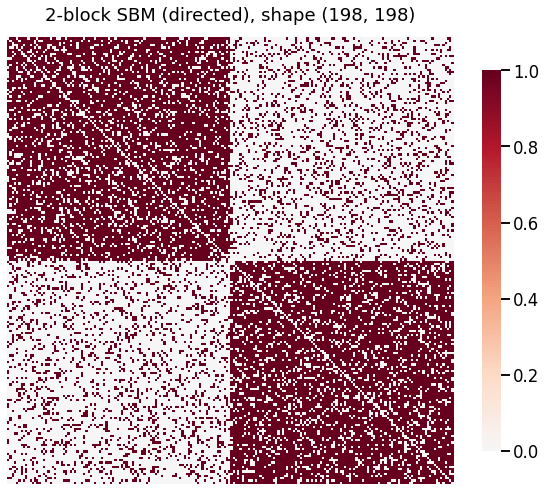

In [10]:
# Generate a directed SBM
directed = sbm(2*[nodes_per_community], P, directed=True)
oos_idx = [0, -1]

# a is a tuple of (out_oos, in_oos)
A, a = remove_vertices(directed, indices=oos_idx, return_removed=True)

# Plot the new adjacency matrix
heatmap(directed, title=f'2-block SBM (directed), shape {A.shape}');

In [11]:
# Fit our directed graph
X_hat_ase, Y_hat_ase = ase.fit_transform(A)

# predicted latent positions
w_ase = ase.transform(a)
print(f"output of `ase.transform(a)` is {type(w_ase)}", "\n")
print(f"out latent positions: \n{w_ase[0]}\n")
print(f"in latent positions: \n{w_ase[1]}")

output of `ase.transform(a)` is <class 'tuple'> 

out latent positions: 
[[ 0.69382889  0.56970396]
 [ 0.71045116 -0.64020639]]

in latent positions: 
[[ 0.68914527  0.46260394]
 [ 0.69295841 -0.60998878]]


### Plotting directed ASE latent predictions

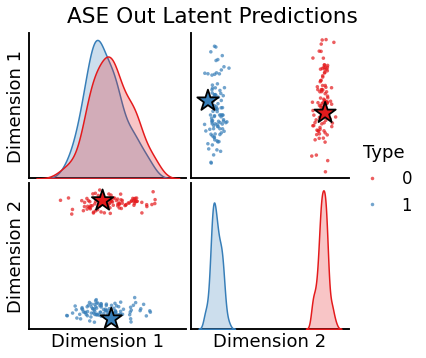

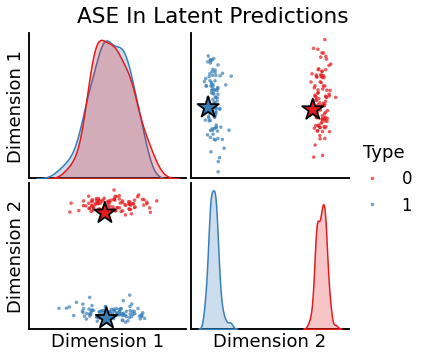

In [12]:
plot_oos(X_hat_ase, w_ase[0], labels, oos_labels=oos_labels, title="ASE Out Latent Predictions")
plot_oos(Y_hat_ase, w_ase[1], labels, oos_labels=oos_labels, title="ASE In Latent Predictions")

In [13]:
# Fit our directed graph
X_hat_lse, Y_hat_lse = lse.fit_transform(A)

# predicted latent positions
w_lse = lse.transform(a)
print(f"output of `ase.transform(a)` is {type(w_lse)}", "\n")
print(f"out latent positions: \n{w_lse[0]}\n")
print(f"in latent positions: \n{w_lse[1]}")

output of `ase.transform(a)` is <class 'tuple'> 

out latent positions: 
[[ 0.0709367   0.05849967]
 [ 0.07096437 -0.06330408]]

in latent positions: 
[[ 0.07113943  0.04806502]
 [ 0.07069668 -0.0611713 ]]


### Plotting directed LSE latent predictions

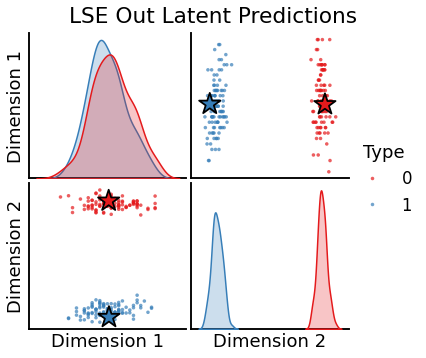

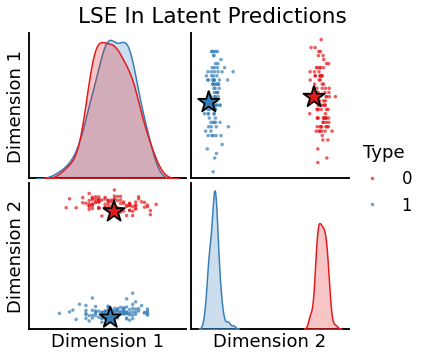

In [14]:
plot_oos(X_hat_lse, w_lse[0], labels, oos_labels=oos_labels, title="LSE Out Latent Predictions")
plot_oos(Y_hat_lse, w_lse[1], labels, oos_labels=oos_labels, title="LSE In Latent Predictions")

## Weighted out-of-sample prediction

Weighted graphs work as well. Here, we generate a directed, weighted graph and estimate the latent positions for multiple out-of-sample vertices.

<Axes: title={'center': '2-block SBM (directed, weighted), shape (198, 198)'}>

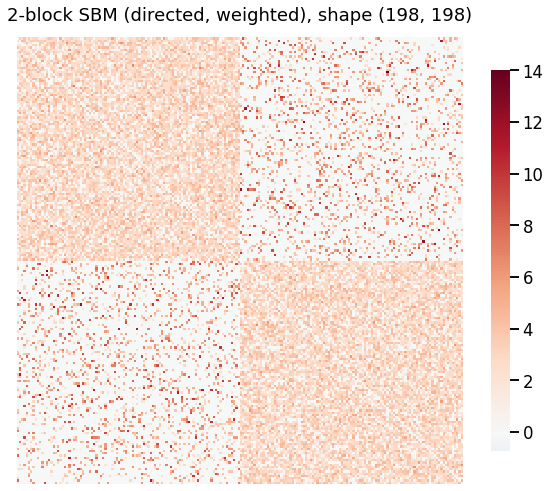

In [15]:
# Generate a weighted, directed SBM
wt = [[normal, poisson],
      [poisson, normal]]
wtargs = [[dict(loc=3, scale=1), dict(lam=5)],
          [dict(lam=5), dict(loc=3, scale=1)]]
weighted = sbm(2*[nodes_per_community], P, wt=wt, wtargs=wtargs, directed=True)

# Generate out-of-sample vertices
oos_idx = [0, -1]
A, a = remove_vertices(weighted, indices=oos_idx, return_removed=True)

# Plot our weighted, directed SBM
heatmap(A, title=f'2-block SBM (directed, weighted), shape {A.shape}')

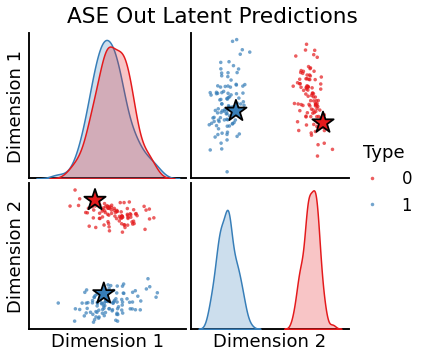

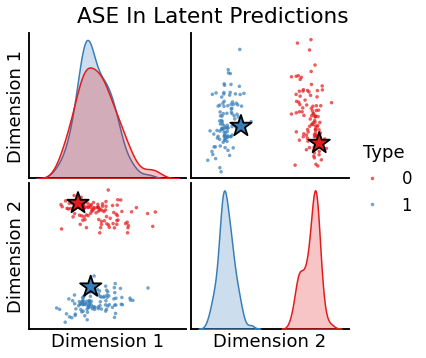

In [16]:
# Embed and transform
X_hat_ase, Y_hat_ase = ase.fit_transform(A)
w_ase = ase.transform(a)

# Plot
plot_oos(X_hat_ase, w_ase[0], labels, oos_labels=oos_labels, title="ASE Out Latent Predictions")
plot_oos(Y_hat_ase, w_ase[1],labels, oos_labels=oos_labels, title="ASE In Latent Predictions")

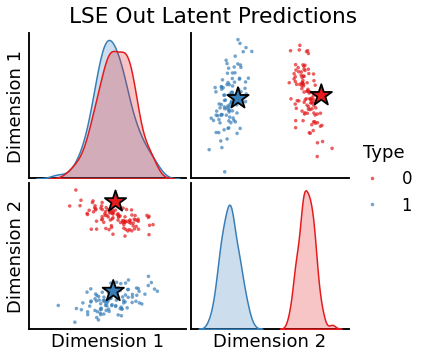

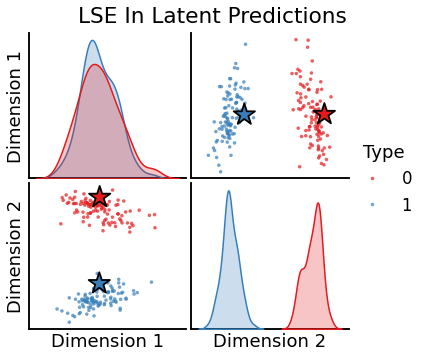

In [17]:
# Embed and transform
X_hat_lse, Y_hat_lse = lse.fit_transform(A)
w_lse = lse.transform(a)

# Plot
plot_oos(X_hat_lse, w_lse[0], labels, oos_labels=oos_labels, title="LSE Out Latent Predictions")
plot_oos(Y_hat_lse, w_lse[1],labels, oos_labels=oos_labels, title="LSE In Latent Predictions")